In [1]:
import pandas as pd
import requests
import math
import yfinance as yf
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use("fivethirtyeight")

In [2]:
aapl = yf.download("AAPL", start="2015-01-01", end="2020-01-01").reset_index()

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Calculate the ROI
buy_price = aapl["Close"].iloc[0]
sell_price = aapl["Close"].iloc[-1]

roi = (sell_price - buy_price) / buy_price * 100

print(f"The ROI for a buy and hold strategy is {roi}%")

The ROI for a buy and hold strategy is 168.59049572710646%


In [4]:
counter = 1
for period in [2, 5, 19]:
    aapl["SMA" + str(counter)] = aapl["Close"].rolling(window=period).mean()
    counter += 1

In [ ]:
aapl

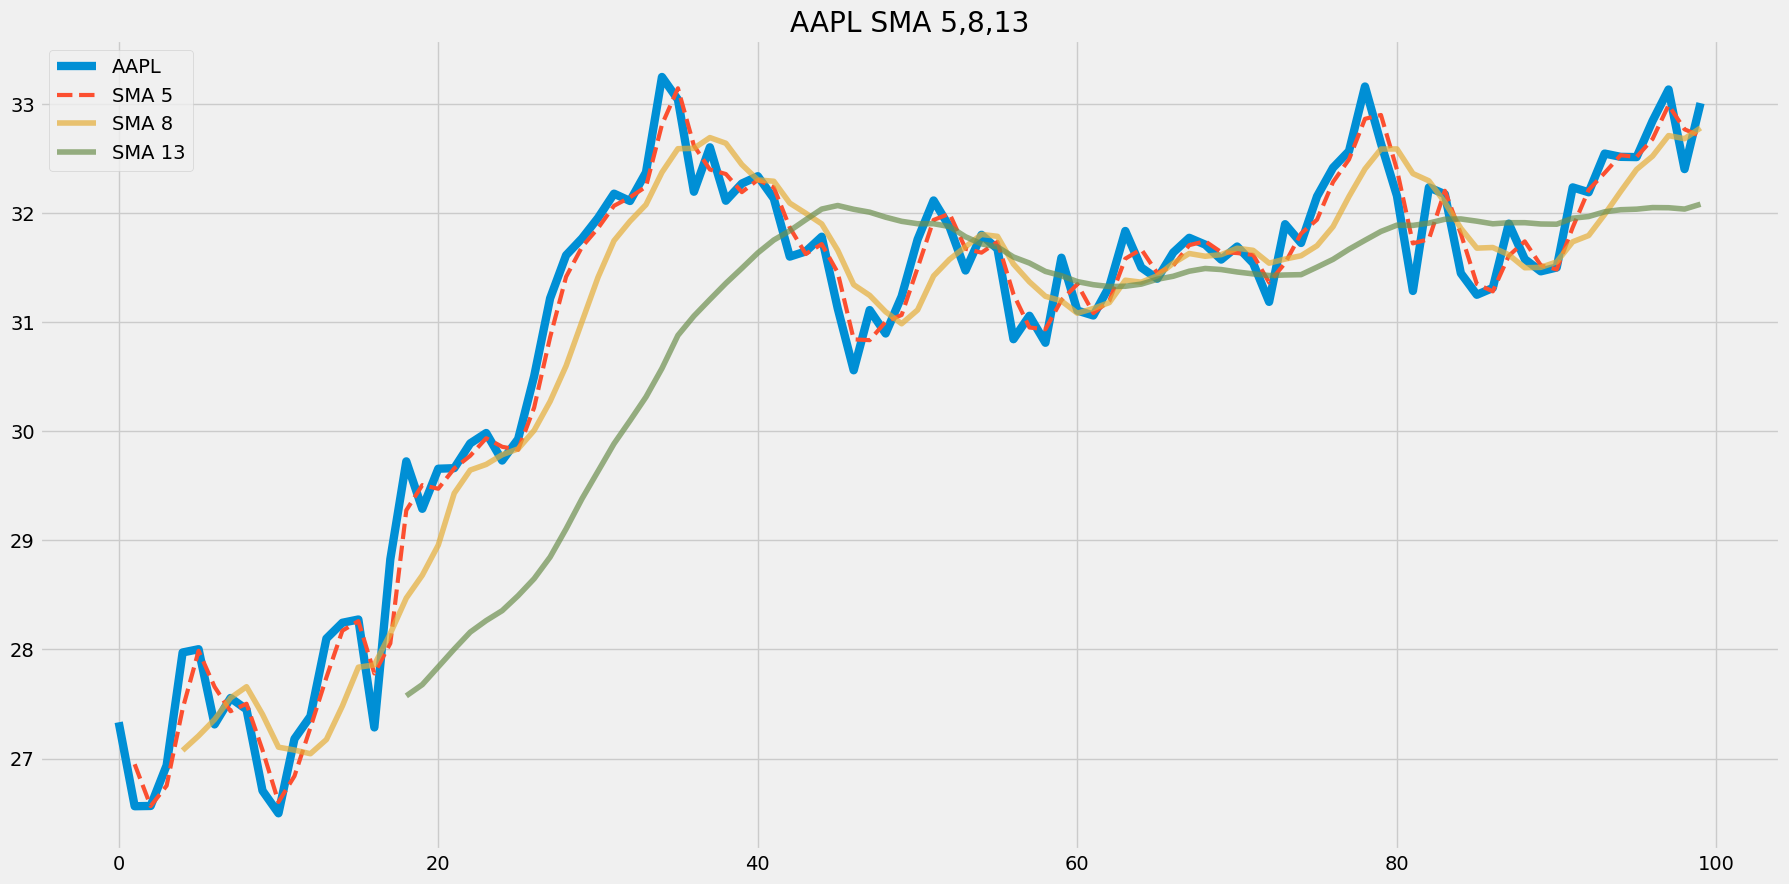

In [5]:
plt.plot(aapl["Close"][:100], label="AAPL", linewidth=6)
plt.plot(aapl["SMA1"][:100], label="SMA 5", linewidth=3, linestyle="--")
plt.plot(aapl["SMA2"][:100], label="SMA 8", linewidth=4, alpha=0.7)
plt.plot(aapl["SMA3"][:100], label="SMA 13", linewidth=4, alpha=0.7)
plt.title("AAPL SMA 5,8,13")
plt.legend()

In [6]:
# counter = 1
# for period in [5, 8, 13]:
#     aapl["SMA" + str(counter)] = aapl["Close"].rolling(window=period).mean()
#     counter += 1

def implement_strategy(aapl, investment):

    in_position = False
    equity = investment

    for i in range(1, len(aapl)):
        if (
            aapl["SMA2"][i - 1] < aapl["SMA3"][i - 1]
            and aapl["SMA2"][i] > aapl["SMA3"][i]
            and aapl["SMA1"][i] > aapl["SMA2"][i]
            and aapl["Close"][i] > aapl["SMA1"][i]
            and in_position == False
        ):
            no_of_shares = math.floor(equity / aapl.Close[i])
            equity -= no_of_shares * aapl.Close[i]
            in_position = True
            print(
                cl("BUY: ", color="green", attrs=["bold"]),
                f'{no_of_shares} Shares are bought at ${aapl.Close[i]} on {str(aapl["Date"][i])[:10]}',
            )
        elif (
            aapl["SMA2"][i - 1] > aapl["SMA3"][i - 1]
            and aapl["SMA2"][i] < aapl["SMA3"][i]
            and aapl["SMA1"][i] < aapl["SMA2"][i]
            and aapl["Close"][i] < aapl["SMA1"][i]
            and in_position == True
        ):
            equity += no_of_shares * aapl.Close[i]
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f'{no_of_shares} Shares are sold at ${aapl.Close[i]} on {str(aapl["Date"][i])[:10]}',
            )
    if in_position == True:
        equity += no_of_shares * aapl.Close[i]
        print(
            cl(
                f'\nClosing position at {aapl.Close[i]} on {str(aapl["Date"][i])[:10]}',
                attrs=["bold"],
            )
        )
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    # return roi
    print(cl(f"EARNING: ${earning} ; ROI: {roi}%", attrs=["bold"]))

In [7]:
implement_strategy(aapl, 10000)

BUY:  314 Shares are bought at $31.837499618530273 on 2015-04-06
SELL:  314 Shares are bought at $31.450000762939453 on 2015-05-05
BUY:  307 Shares are bought at $32.127498626708984 on 2015-07-16
SELL:  307 Shares are bought at $30.6924991607666 on 2015-07-27
BUY:  330 Shares are bought at $28.552499771118164 on 2015-09-11
SELL:  330 Shares are bought at $27.264999389648438 on 2015-09-29
BUY:  316 Shares are bought at $28.4424991607666 on 2015-10-20
SELL:  316 Shares are bought at $28.084999084472656 on 2015-11-13
BUY:  373 Shares are bought at $23.80500030517578 on 2016-05-20
SELL:  373 Shares are bought at $24.28499984741211 on 2016-06-15
BUY:  375 Shares are bought at $24.170000076293945 on 2016-07-08
SELL:  375 Shares are bought at $26.704999923706055 on 2016-08-29
BUY:  347 Shares are bought at $28.892499923706055 on 2016-09-15
SELL:  347 Shares are bought at $28.43000030517578 on 2016-10-28
BUY:  353 Shares are bought at $27.950000762939453 on 2016-11-22
SELL:  353 Shares are bou

In [ ]:
from scipy.optimize import brute

# Define ranges for periods
ranges = (slice(1, 50, 1), slice(1, 50, 1), slice(1, 50, 1))

def fitness_func(periods):
    period1, period2, period3 = periods
    # Ensure periods are integers
    period1, period2, period3 = int(period1), int(period2), int(period3)
    
    # Check if periods meet the constraint
    if not (period1 < period2 < period3):
        return 1e6  # Return a large value if constraint is not met
    
    # Calculate SMAs
    aapl["SMA1"] = aapl["Close"].rolling(window=period1).mean()
    aapl["SMA2"] = aapl["Close"].rolling(window=period2).mean()
    aapl["SMA3"] = aapl["Close"].rolling(window=period3).mean()
    
    # Implement strategy and calculate ROI
    roi = implement_strategy(aapl, 10000)
    return -roi  # Negate ROI because brute() minimizes the function

# Perform brute-force optimization
solution = brute(fitness_func, ranges, full_output=True, finish=None)

print("Parameters of the best solution : {solution}".format(solution=solution[0]))